In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../../../')
from utils.plot import figsize, fig_save_and_show, config_matplotlib
from helper import plot_hull_position

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Hydrostatics studies: exploring the _wetted surface area_ and _trim_ as functions of _center of gravity_ and _displacement mass_.

## Load the geometry file
![](models/hull.jpeg "Hull.stl")

In [2]:
### Load the geometry file
# !pip install https://github.com/LHEEA/meshmagick/archive/refs/tags/3.4.zip
import os
from meshmagick import mmio, mesh, hydrostatics

path = os.getcwd() + "/data/"
file = "hull_decimated.stl"

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

# Check if the mesh is closed too:
print("Is it closed?", mymesh.is_mesh_closed())

# And inspect the mesh quality
mymesh.print_quality()

Is it closed? True

Triangle quality of the mesh (3058 elements):

 Area Ratio:
    range: 2.46059e-06  -  0.764683
    average: 0.00436667  , standard deviation: 0.021189
 Edge Ratio:
    range: 1.05375  -  292.434
    average: 4.98603  , standard deviation: 9.38413
 Aspect Ratio:
    range: 1.02308  -  1543.48
    average: 9.39826  , standard deviation: 45.0916
 Radius Ratio:
    range: 1.00217  -  893321
    average: 666.833  , standard deviation: 18127.9
 Frobenius Norm:
    range: 1.00195  -  1157.63
    average: 7.84704  , standard deviation: 35.7671
 Minimal Angle:
    range: 0.042533  -  57.0344
    average: 13.239  , standard deviation: 10.2038

Quadrilateral quality of the mesh (0 elements):

 Area Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Edge Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Aspect Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Radius Ratio:
    range: 0  -  0
    average: 0  , standard deviation

## Simulation with the hydrostatics solver
With the Mesh loaded we can create a simulation (using the hydrostatics solver) to get data to model the hull behaviour. We want to set the **displacement mass** (in TONS) and its **c.o.g.** (center of gravity) location ($x, y, z$ in meters, relative to the model's origin), and get the hull resulting **trim** and its **wetted surface area**.

In [3]:
### Simulate:
# !pip install tqdm ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial import ConvexHull
from meshmagick import densities
import multiprocessing as mp
from IPython.utils import io
from tqdm.autonotebook import tqdm


def _plane_intersection_points(verts, faces, axis, value, *, eps=1e-12):
    pts = []
    for tri in faces:
        p = verts[tri]
        d = p[:, axis] - value
        if (d > 0).all() or (d < 0).all():
            continue
        for i, j in ((0, 1), (1, 2), (2, 0)):
            di, dj = d[i], d[j]
            pi, pj = p[i], p[j]
            if abs(di) <= eps and abs(dj) <= eps:
                pts.append(pi)
                pts.append(pj)
                continue
            if abs(di) <= eps:
                pts.append(pi)
                continue
            if abs(dj) <= eps:
                pts.append(pj)
                continue
            if di * dj < 0.0:
                t = -di / (dj - di)
                pts.append(pi + t * (pj - pi))
    if not pts:
        return np.zeros((0, 3), dtype=float)
    pts = np.asarray(pts, dtype=float)
    pts = np.unique(np.round(pts, 8), axis=0)
    return pts

def _waterplane_metrics(mymesh, *, waterplane_z=0.0):
    verts = mymesh.vertices
    faces = np.asarray(mymesh.faces)[:, :3].astype(int)
    pts = _plane_intersection_points(verts, faces, axis=2, value=waterplane_z)
    if pts.shape[0] < 3:
        bwl = float(verts[:, 1].max() - verts[:, 1].min())
        lwl = float(verts[:, 0].max() - verts[:, 0].min())
        awp = float(0.0)
        x_min = float(verts[:, 0].min())
        x_max = float(verts[:, 0].max())
        return bwl, lwl, awp, x_min, x_max
    x_min = float(np.min(pts[:, 0]))
    x_max = float(np.max(pts[:, 0]))
    y_min = float(np.min(pts[:, 1]))
    y_max = float(np.max(pts[:, 1]))
    bwl = y_max - y_min
    lwl = x_max - x_min
    try:
        awp = float(ConvexHull(pts[:, :2]).volume)
    except Exception:
        awp = float(0.0)
    return bwl, lwl, awp, x_min, x_max


def simulate(mymesh, cog_x, mass, verbose=True):
    kg_to_tons = 1000
    disp = mass / kg_to_tons
    cog = np.array([cog_x, 0, 0])
    water_density = densities.get_density("SALT_WATER")
    grav = 9.81
    reltol = 1e-4
    z_corr, rotmat_corr = hydrostatics.full_equilibrium(
        mymesh,
        cog,
        disp,
        water_density,
        grav,
        reltol=reltol,
        verbose=verbose,
    )
    hs_data = hydrostatics.compute_hydrostatics(
        mymesh,
        cog,
        water_density,
        grav,
        z_corr=z_corr,
        rotmat_corr=rotmat_corr,
        at_cog=True,
    )

    mymesh.rotate_matrix(rotmat_corr)
    mymesh.translate_z(z_corr)

    bwl, lwl, awp, x_wl_min, x_wl_max = _waterplane_metrics(mymesh, waterplane_z=0.0)

    r = R.from_matrix(hs_data["rotmat_eq"])
    angles_deg = r.as_euler("xyz", degrees=True)

    verts = mymesh.vertices

    x_mid = float(np.nan)
    if np.isfinite(x_wl_min) and np.isfinite(x_wl_max):
        x_mid = 0.5 * (x_wl_min + x_wl_max)

    draft_keel_m = float(-np.min(verts[:, 2]))
    draft_aft_m = float(np.nan)
    draft_fwd_m = float(np.nan)
    if np.isfinite(x_wl_min) and np.isfinite(x_wl_max) and np.isfinite(lwl) and lwl > 0:
        dx = max(0.02 * lwl, 0.05)
        aft_mask = verts[:, 0] <= (x_wl_min + dx)
        fwd_mask = verts[:, 0] >= (x_wl_max - dx)
        if np.any(aft_mask):
            draft_aft_m = float(-np.min(verts[aft_mask, 2]))
        if np.any(fwd_mask):
            draft_fwd_m = float(-np.min(verts[fwd_mask, 2]))

    draft_mean_m = float(np.nanmean([draft_aft_m, draft_fwd_m])) if (np.isfinite(draft_aft_m) or np.isfinite(draft_fwd_m)) else draft_keel_m

    disp_volume_m3 = float(hs_data["disp_mass"]) / float(water_density)

    CWP = float(np.nan)
    CB = float(np.nan)
    CM = float(np.nan)
    CP = float(np.nan)
    if np.isfinite(lwl) and lwl > 0 and np.isfinite(bwl) and bwl > 0:
        if np.isfinite(awp) and awp > 0:
            CWP = float(awp / (lwl * bwl))
        if np.isfinite(draft_keel_m) and draft_keel_m > 0 and np.isfinite(disp_volume_m3) and disp_volume_m3 > 0:
            CB = float(disp_volume_m3 / (lwl * bwl * draft_keel_m))

    A_mid_m2 = float(np.nan)
    if np.isfinite(x_mid) and np.isfinite(lwl) and lwl > 0 and np.isfinite(draft_keel_m) and draft_keel_m > 0 and np.isfinite(bwl) and bwl > 0:
        faces = np.asarray(mymesh.faces)[:, :3].astype(int)
        pts_mid = _plane_intersection_points(verts, faces, axis=0, value=x_mid)
        # submerged part only
        pts_mid = pts_mid[pts_mid[:, 2] <= 1e-6]
        yz = pts_mid[:, [1, 2]]
        if yz.shape[0] >= 3:
            try:
                A_mid_m2 = float(ConvexHull(yz).volume)
                if np.isfinite(A_mid_m2) and A_mid_m2 > 0:
                    CM = float(A_mid_m2 / (bwl * draft_keel_m))
            except Exception:
                A_mid_m2 = float(np.nan)
                CM = float(np.nan)
        if np.isfinite(CB) and CB > 0 and np.isfinite(CM) and CM > 0:
            CP = float(CB / CM)

    lcb_percent = float(np.nan)
    if np.isfinite(x_mid) and np.isfinite(lwl) and lwl > 0:
        lcb_m = float(hs_data["buoyancy_center"][0]) - x_mid
        lcb_percent = float(100.0 * lcb_m / lwl)

    return {
        "disp_mass": hs_data["disp_mass"],
        "disp_volume_m3": disp_volume_m3,
        "cog_x": hs_data["cog"][0],
        "cog_y": hs_data["cog"][1],
        "cog_z": hs_data["cog"][2],
        "wet_surface_area": hs_data["wet_surface_area"],
        "cob_x": hs_data["buoyancy_center"][0],
        "cob_y": hs_data["buoyancy_center"][1],
        "cob_z": hs_data["buoyancy_center"][2],
        "lcb_percent": lcb_percent,
        "A_mid_m2": A_mid_m2,
        "angles_deg_x": angles_deg[0],
        "angles_deg_y": angles_deg[1],
        "angles_deg_z": angles_deg[2],
        "LWL": lwl,
        "BWL": bwl,
        "AWP": awp,
        "CWP": CWP,
        "CB": CB,
        "CM": CM,
        "CP": CP,
        "draft_keel_m": draft_keel_m,
        "draft_mean_m": draft_mean_m,
        "draft_aft_m": draft_aft_m,
        "draft_fwd_m": draft_fwd_m,
        "x_wl_min": x_wl_min,
        "x_wl_max": x_wl_max,
    }


def parallel_simulate(args):
    VF, data = args
    mymesh = mesh.Mesh(*VF)

    with io.capture_output() as _:  # Supress every text output from simulate
        try:
            result = simulate(mymesh, cog_x=data[0], mass=data[1], verbose=False)
        except Exception:
            result = None
    return result


/tmp/ipykernel_1463286/2067080568.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
### Run the simulations grid
VF = (V, F)

cog_x_grid = np.linspace(1.0, 4.0, 100)
disp_mass_grid = np.linspace(100, 400, 100)
grid = [(cx, m) for cx in cog_x_grid for m in disp_mass_grid]

with mp.Pool(mp.cpu_count()) as pool:
    results = list(
        tqdm(pool.imap(parallel_simulate, [(VF, g) for g in grid]), total=len(grid))
    )


  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
### Store the simulations's output to a file:
df = pd.DataFrame([r for r in results if r])
df.to_feather("data/meshmagick.feather")

## Operating point params

In [6]:
import os
import numpy as np
from meshmagick import mmio, mesh, hydrostatics
from meshmagick.mesh_clipper import MeshClipper
from meshmagick.mesh import Plane

# --- Load and clean mesh ---
path = os.getcwd() + '/data/'
file = "hull_decimated.stl"

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

print(f"Loaded mesh: {mymesh.nb_faces} faces")
print(f"isclosed? {mymesh.is_mesh_closed()}")

# Aggressive cleanup
# mymesh.heal_mesh()
mean_area = np.mean(mymesh.faces_areas)
mymesh.remove_degenerated_faces(rtol=1e-2)  # Remove very small faces
mymesh.merge_duplicates(atol=1e-5)
print(f"After cleanup: {mymesh.nb_faces} faces")

# --- Remove deck ---
face_centers = mymesh.faces_centers
face_normals = mymesh.faces_normals
z_max = np.max(face_centers[:, 2])
deck_mask = (face_centers[:, 2] > (z_max - 1e-3)) & (face_normals[:, 2] > 0.9)
hull_mesh = mymesh.extract_faces(np.where(~deck_mask)[0])

# hull_mesh.heal_mesh()
print(f"Hull-only: {hull_mesh.nb_faces} faces, closed? {hull_mesh.is_mesh_closed()}")

# --- Align to waterplane ---
z_top = np.max(hull_mesh.vertices[:, 2])
hull_mesh.translate([0, 0, -z_top])
# hull_mesh.show()

# --- Clip just below deck edge ---
waterplane = Plane(normal=[0, 0, 1], scalar=1e-6)  # Slightly below z=0
clipper = MeshClipper(hull_mesh, plane=waterplane, assert_closed_boundaries=False, verbose=False)
wet_area = np.sum(clipper.clipped_mesh.faces_areas)
total_area = np.sum(hull_mesh.faces_areas)

print(f"\n✅ Total hull area: {total_area:.6f} m²")
print(f"Wetted area (at deck edge): {wet_area:.6f} m²")
print(f"error: {abs(total_area - wet_area):.2e} m²")

Loaded mesh: 3058 faces
isclosed? True
After cleanup: 2991 faces
FOUND OPEN BOUNDARY!!!
Hull-only: 2621 faces, closed? False

✅ Total hull area: 8.238401 m²
Wetted area (at deck edge): 8.238401 m²
error: 0.00e+00 m²


In [7]:
from utils.optimization import save_model_params_to_json

hull_params = dict(
    total_area=total_area,
    cog_x=1.9760,
    disp_mass=293.7,
)

save_model_params_to_json(path + 'hull_input_params.json', hull_params)

# Hull Total Surface Area

In [8]:
import os
import numpy as np
from meshmagick import mmio, mesh, hydrostatics
from meshmagick.mesh_clipper import MeshClipper
from meshmagick.mesh import Plane

# --- Load and clean mesh ---
path = os.getcwd() + '/data/'
file = "hull.stl"

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

print(f"Loaded mesh: {mymesh.nb_faces} faces")
print(f"isclosed? {mymesh.is_mesh_closed()}")

# Aggressive cleanup
# mymesh.heal_mesh()
mean_area = np.mean(mymesh.faces_areas)
mymesh.remove_degenerated_faces(rtol=1e-2)  # Remove very small faces
mymesh.merge_duplicates(atol=1e-5)
print(f"After cleanup: {mymesh.nb_faces} faces")

# --- Remove deck ---
face_centers = mymesh.faces_centers
face_normals = mymesh.faces_normals
z_max = np.max(face_centers[:, 2])
deck_mask = (face_centers[:, 2] > (z_max - 1e-3)) & (face_normals[:, 2] > 0.9)
hull_mesh = mymesh.extract_faces(np.where(~deck_mask)[0])

# hull_mesh.heal_mesh()
print(f"Hull-only: {hull_mesh.nb_faces} faces, closed? {hull_mesh.is_mesh_closed()}")

# --- Align to waterplane ---
z_top = np.max(hull_mesh.vertices[:, 2])
hull_mesh.translate([0, 0, -z_top])
# hull_mesh.show()

# --- Clip just below deck edge ---
waterplane = Plane(normal=[0, 0, 1], scalar=1e-6)  # Slightly below z=0
clipper = MeshClipper(hull_mesh, plane=waterplane, assert_closed_boundaries=False, verbose=False)
wet_area = np.sum(clipper.clipped_mesh.faces_areas)
total_area = np.sum(hull_mesh.faces_areas)

print(f"\n✅ Total hull area: {total_area:.6f} m²")
print(f"Wetted area (at deck edge): {wet_area:.6f} m²")
print(f"error: {abs(total_area - wet_area):.2e} m²")

Loaded mesh: 305804 faces
isclosed? True
After cleanup: 305804 faces
Hull-only: 201856 faces, closed? False

✅ Total hull area: 8.237900 m²
Wetted area (at deck edge): 8.237900 m²
error: 0.00e+00 m²


## Load, Filter and Plot
To avoid some inconsistency on the dataset (for example, when the simulation doesn't converge), we can filter any abrupt angle in Y axis. We can consider only angles less than 10°.

,disp_mass,disp_volume_m3,cog_x,cog_y,cog_z,wet_surface_area,cob_x,cob_y,cob_z,lcb_percent,...,CWP,CB,CM,CP,draft_keel_m,draft_mean_m,draft_aft_m,draft_fwd_m,x_wl_min,x_wl_max
0,100.025973,0.097586,1.0,0.0,0.0,2.145047,0.982101,5.077237e-05,-0.292697,-17.099326,...,0.816367,0.387563,0.412190,0.940254,0.101098,0.049049,0.101098,-0.003000,0.013593,2.957326
1,103.034501,0.100521,1.0,0.0,0.0,2.163425,0.981181,-4.500575e-05,-0.291682,-17.158769,...,0.814061,0.385318,0.404387,0.952846,0.103645,0.050379,0.103645,-0.002887,0.013601,2.959837
2,106.066496,0.103480,1.0,0.0,0.0,2.183886,0.981159,-3.000965e-05,-0.290725,-17.213034,...,0.812466,0.384092,0.389672,0.985680,0.105984,0.051688,0.105984,-0.002607,0.013580,2.964688
3,109.090666,0.106430,1.0,0.0,0.0,2.202581,0.980873,-5.401333e-07,-0.289759,-17.243643,...,0.810774,0.382807,0.376996,1.015415,0.108410,0.052961,0.108410,-0.002489,0.013576,2.966581
4,112.167419,0.109432,1.0,0.0,0.0,2.222189,0.981700,-1.337699e-05,-0.288857,-17.247855,...,0.809081,0.381715,0.364588,1.046976,0.110786,0.054237,0.110786,-0.002311,0.013551,2.969536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,369.664904,0.360649,4.0,0.0,0.0,3.725971,4.021386,2.197178e-05,-0.243805,6.713013,...,0.663697,0.280660,0.347370,0.807957,0.303258,0.153422,0.003586,0.303258,1.654746,5.827756
9952,375.773888,0.366609,4.0,0.0,0.0,3.755095,4.022171,1.797797e-05,-0.242291,7.438877,...,0.670249,0.283350,0.353608,0.801311,0.307974,0.155890,0.003807,0.307974,1.652655,5.777937
9953,378.767783,0.369530,4.0,0.0,0.0,3.769219,4.021991,-1.985911e-06,-0.241601,7.845447,...,0.674123,0.284902,0.316615,0.899838,0.310679,0.157168,0.003657,0.310679,1.653752,5.747832
9954,381.823082,0.372510,4.0,0.0,0.0,3.784419,4.022206,-2.023588e-06,-0.240861,8.209332,...,0.677242,0.286296,0.353136,0.810727,0.313028,0.158393,0.003758,0.313028,1.652798,5.723293


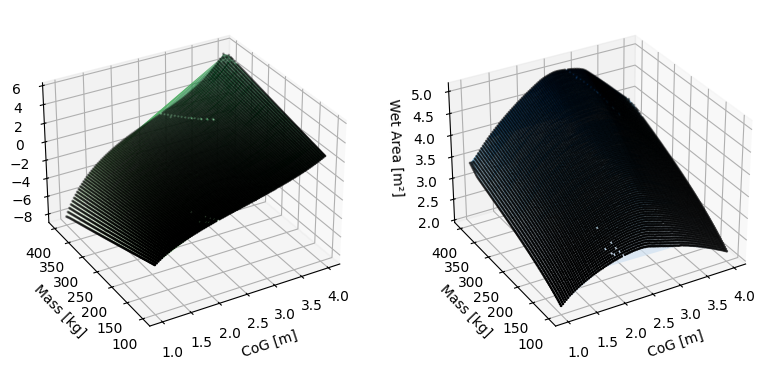

,count,mean,std,min,25%,50%,75%,max
disp_mass,9956.0,249.681031,87.281041,99.795417,172.791050,248.500279,324.256232,400.063650
disp_volume_m3,9956.0,0.243591,0.085152,0.097361,0.168577,0.242439,0.316348,0.390306
cog_x,9956.0,2.496975,0.874226,1.000000,1.727273,2.484848,3.242424,4.000000
cog_y,9956.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cog_z,9956.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wet_surface_area,9956.0,3.679310,0.636119,2.145047,3.187726,3.674287,4.171844,4.986393
cob_x,9956.0,2.494852,0.885147,0.970641,1.718118,2.483736,3.250202,4.022257
cob_y,9956.0,-0.000002,0.000069,-0.000975,-0.000020,-0.000002,0.000016,0.000802
cob_z,9956.0,-0.296185,0.022675,-0.338162,-0.312781,-0.297999,-0.283600,-0.210207
lcb_percent,9956.0,-6.475109,7.172828,-20.307842,-13.252046,-6.526236,0.588794,8.969694


In [9]:
### Plot:
# %matplotlib notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

def load_dataset():
    df = pd.read_feather('data/meshmagick.feather')
    df = df[abs(df['angles_deg_y']) < 10].reset_index(drop=True)
    return df

def plot_dataset(df: pd.DataFrame):
    fig = plt.figure(figsize=plt.figaspect(1/2))

    X = df['cog_x']
    Y = df['disp_mass']

    Z = df['angles_deg_y']
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap='Greens', edgecolor=None, alpha=0.7)
    ax.scatter(X, Y, Z, c='black', s=1)
    ax.set_xlabel('CoG [m]')
    ax.set_ylabel('Mass [kg]')
    ax.set_zlabel('Trim [Deg]')
    ax.view_init(elev=30, azim=-120)

    Z = df['wet_surface_area']
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap='Blues', edgecolor=None, alpha=0.7)
    ax.scatter(X, Y, Z, c='black', s=1)
    ax.set_xlabel('CoG [m]')
    ax.set_ylabel('Mass [kg]')
    ax.set_zlabel('Wet Area [m²]')
    ax.view_init(elev=30, azim=-120)

    plt.show()

df = load_dataset()
display(df)
plot_dataset(df)

display(df.describe().T)

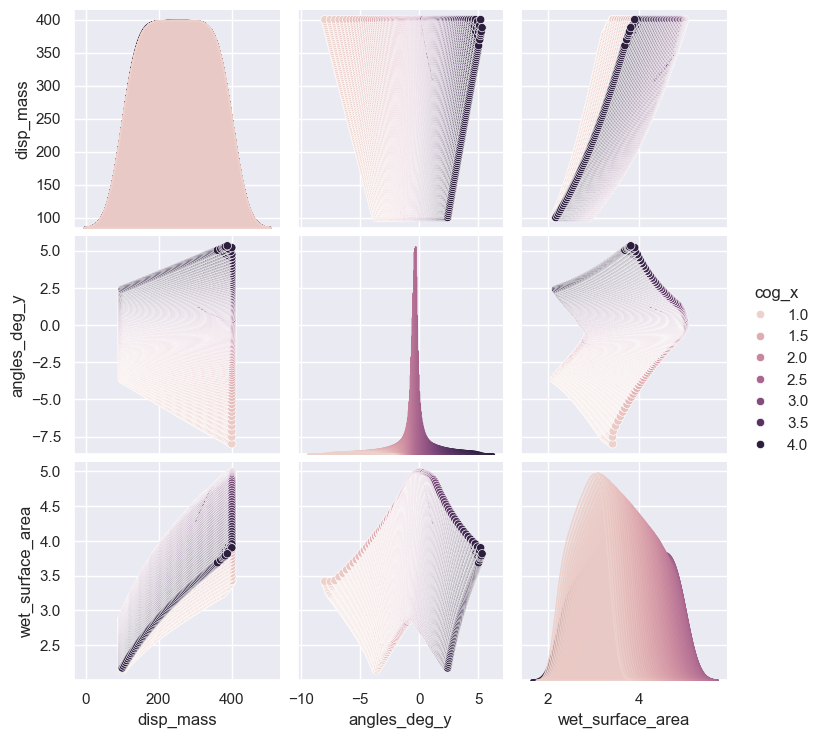

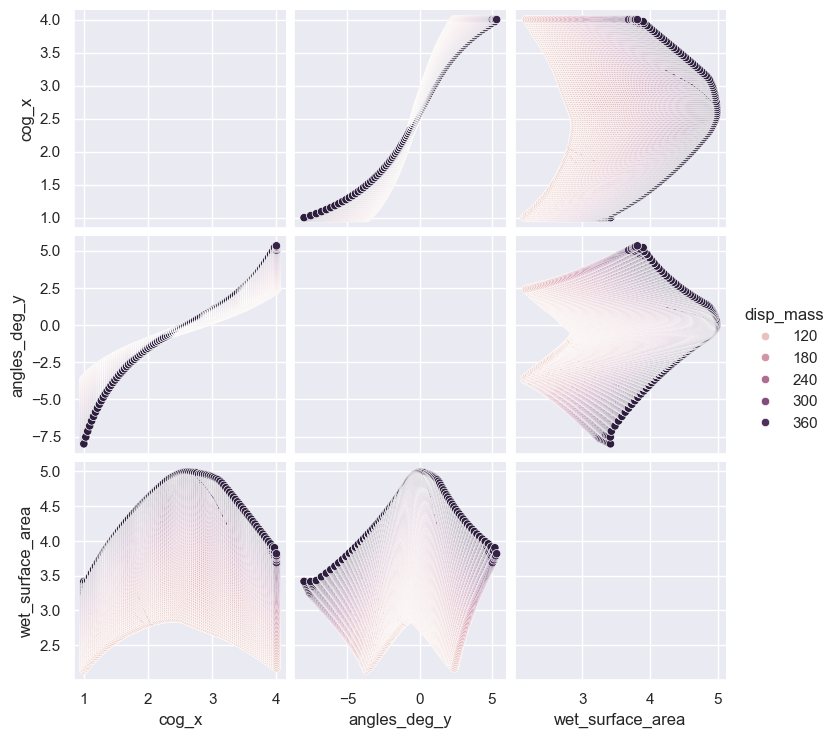

In [10]:
%matplotlib inline
import seaborn as sns
sns.set_theme()

sns.pairplot(df[['cog_x', 'disp_mass', 'angles_deg_y', 'wet_surface_area']], hue='cog_x')
plt.show()

sns.pairplot(df[['cog_x', 'disp_mass', 'angles_deg_y', 'wet_surface_area']], hue='disp_mass')
plt.show()

### Observations
- The greater the **displacement mass**, greater the **wetted surface area**;
- The **displacement mass** doesn't correlate well with the **y angle (trim)**;
- The greater the **cog x**, greater the **y angle (trim)**;
- The lowest **wetted surface area** occur with the **displacement mass**, but also with higher **cog x**;

## Visually understanding the change in CoG:

#### Case 1:
- mass = 265kg
- cog_x = 1m

![](data/hull_265kg_1m.jpeg)

#### Case 2:
- mass = 265kg
- cog_x = 4m

![](data/hull_265kg_4m.jpeg)

In [11]:
def plot_hull_position(result, mesh):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.tri import Triangulation
    from utils.plot import figsize

    V_eq = mesh.vertices
    triangles = np.asarray(getattr(mesh, "faces", None))[:, :3].astype(int)

    tri = Triangulation(V_eq[:, 0], V_eq[:, 2], triangles)

    fig, ax = plt.subplots(
        figsize=figsize(subplots=(1, 2)),
        constrained_layout=True
    )

    ax.triplot(tri, color="gray", linewidth=0.2, alpha=1, label="Hull")
    ax.axhline(0.0, color="blue", linewidth=2, alpha=0.5, label="Waterplane")

    cog_x = result.get("cog_x", 0.0)
    cog_z = result.get("cog_z", 0.0)
    ax.scatter([cog_x], [cog_z], color="red", s=20, marker="^")

    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")

    # prevent geometric distortion
    ax.set_aspect("equal", adjustable="box")

    return fig


3DOF equilibrium
Target diplacement:    0.100 tons
COG pos:  [1 0 0]
No convergence after 100


{'disp_mass': 100.02597336310727,
 'disp_volume_m3': 0.09758631547620221,
 'cog_x': 1,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.1450472160765566,
 'cob_x': 0.9821010620912412,
 'cob_y': 5.0772368836829556e-05,
 'cob_z': -0.29269661577895106,
 'lcb_percent': -17.099325616121806,
 'A_mid_m2': 0.035256991814629046,
 'angles_deg_x': -0.007125074715718516,
 'angles_deg_y': -3.6433057847235673,
 'angles_deg_z': 0.001523578224169389,
 'LWL': 2.94373307,
 'BWL': 0.84607144,
 'AWP': 2.03325120844424,
 'CWP': 0.8163672559552874,
 'CB': 0.3875628917856925,
 'CM': 0.4121895227450691,
 'CP': 0.9402541073936814,
 'draft_keel_m': 0.101097699005507,
 'draft_mean_m': 0.04904873967100726,
 'draft_aft_m': 0.101097699005507,
 'draft_fwd_m': -0.0030002196634924816,
 'x_wl_min': 0.01359303,
 'x_wl_max': 2.9573261}

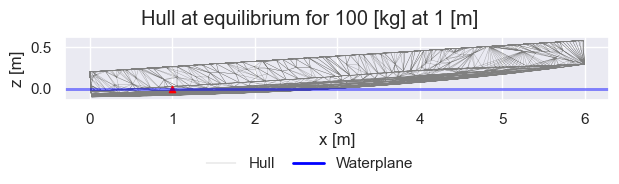

3DOF equilibrium
Target diplacement:    0.100 tons
COG pos:  [2 0 0]
	>>> Convergence reached in 5 iterations


{'disp_mass': 99.99550718462591,
 'disp_volume_m3': 0.09755659237524479,
 'cog_x': 2,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.81776200769632,
 'cob_x': 1.993495798107794,
 'cob_y': 1.7456179948768573e-05,
 'cob_z': -0.3307127846704535,
 'lcb_percent': -6.887662970850571,
 'A_mid_m2': 0.03116914705111725,
 'angles_deg_x': 0.0019463058104964546,
 'angles_deg_y': -1.110456714848599,
 'angles_deg_z': 0.00021965016532779459,
 'LWL': 4.6095212299999995,
 'BWL': 0.7863709,
 'AWP': 2.7623204293334065,
 'CWP': 0.7620628698960964,
 'CB': 0.41868345339398516,
 'CM': 0.6166090761073875,
 'CP': 0.6790095534063596,
 'draft_keel_m': 0.06428173218013161,
 'draft_mean_m': 0.01734416530441349,
 'draft_aft_m': 0.029999722809912532,
 'draft_fwd_m': 0.004688607798914446,
 'x_wl_min': 0.00622347,
 'x_wl_max': 4.6157447}

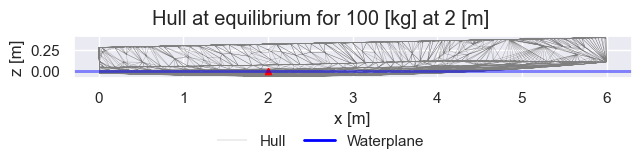

3DOF equilibrium
Target diplacement:    0.100 tons
COG pos:  [3 0 0]
No convergence after 100


{'disp_mass': 100.01274119761133,
 'disp_volume_m3': 0.09757340604645008,
 'cog_x': 3,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.706066185745568,
 'cob_x': 3.0014669734380304,
 'cob_y': -0.0003906250841349561,
 'cob_z': -0.3374596346289843,
 'lcb_percent': -3.9787321633707142,
 'A_mid_m2': 0.034246301087724744,
 'angles_deg_x': 0.00857759457197153,
 'angles_deg_y': 0.340430263561307,
 'angles_deg_z': 1.1804235144239328e-05,
 'LWL': 5.22643679,
 'BWL': 0.7695419,
 'AWP': 2.6383665221481536,
 'CWP': 0.6559899019730357,
 'CB': 0.32534029416566246,
 'CM': 0.5967958060559518,
 'CP': 0.5451450745201125,
 'draft_keel_m': 0.07456853945858388,
 'draft_mean_m': 0.004340867452759745,
 'draft_aft_m': 0.002203229228578907,
 'draft_fwd_m': 0.0064785056769405824,
 'x_wl_min': 0.5961945,
 'x_wl_max': 5.82263129}

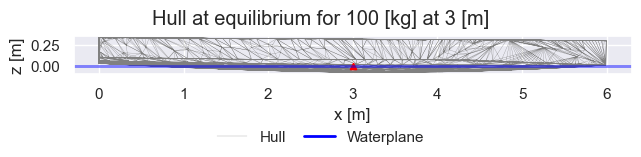

3DOF equilibrium
Target diplacement:    0.100 tons
COG pos:  [4 0 0]
	>>> Convergence reached in 6 iterations


{'disp_mass': 100.00398609093992,
 'disp_volume_m3': 0.09756486447896577,
 'cog_x': 4,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.17511683234623,
 'cob_x': 4.013312311578909,
 'cob_y': -7.519615430428187e-06,
 'cob_z': -0.31537455059087444,
 'lcb_percent': 1.8355038311499787,
 'A_mid_m2': 0.034593345788682846,
 'angles_deg_x': 0.00368418974662871,
 'angles_deg_y': 2.4023030963747383,
 'angles_deg_z': 0.0006066851436977678,
 'LWL': 4.081336159999999,
 'BWL': 0.70456747,
 'AWP': 1.9954311412964931,
 'CWP': 0.6939238124030019,
 'CB': 0.331465271849613,
 'CM': 0.47966664848368695,
 'CP': 0.6910325595857763,
 'draft_keel_m': 0.10236004246714575,
 'draft_mean_m': 0.04300729141604112,
 'draft_aft_m': 0.0017936200621470055,
 'draft_fwd_m': 0.08422096276993524,
 'x_wl_min': 1.89773115,
 'x_wl_max': 5.97906731}

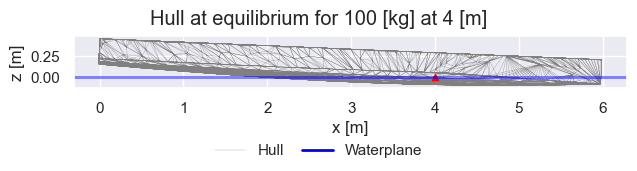

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [1 0 0]
	>>> Convergence reached in 7 iterations


{'disp_mass': 265.0105933605299,
 'disp_volume_m3': 0.2585469203517365,
 'cog_x': 1,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.8861172484815887,
 'cob_x': 0.9740885566406935,
 'cob_y': -5.456059558334249e-06,
 'cob_z': -0.2451956531979322,
 'lcb_percent': -17.549457679417337,
 'A_mid_m2': 0.08832750725162086,
 'angles_deg_x': 0.0024155159543233387,
 'angles_deg_y': -6.046903740253058,
 'angles_deg_z': -0.00035505015187720887,
 'LWL': 2.97529196,
 'BWL': 1.02461637,
 'AWP': 2.491333168681779,
 'CWP': 0.8172236590871257,
 'CB': 0.3751548808687188,
 'CM': 0.3813263309878767,
 'CP': 0.9838158301233225,
 'draft_keel_m': 0.22606737375652952,
 'draft_mean_m': 0.11233550999474379,
 'draft_aft_m': 0.22606737375652952,
 'draft_fwd_m': -0.0013963537670419607,
 'x_wl_min': 0.00859018,
 'x_wl_max': 2.98388214}

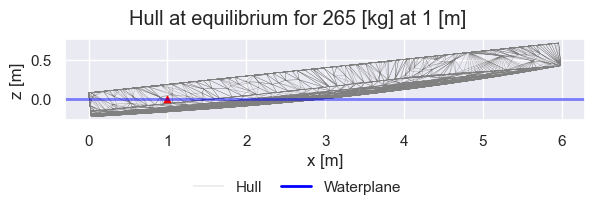

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [2 0 0]
	>>> Convergence reached in 5 iterations


{'disp_mass': 265.0198487697681,
 'disp_volume_m3': 0.25855595001928594,
 'cog_x': 2,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 4.018979689666419,
 'cob_x': 1.993453700486883,
 'cob_y': 2.9316006185550192e-05,
 'cob_z': -0.3010113489145685,
 'lcb_percent': -11.91623664640227,
 'A_mid_m2': 0.05650399565611074,
 'angles_deg_x': -0.004340517205257502,
 'angles_deg_y': -1.3039598506591081,
 'angles_deg_z': 9.40661491628392e-05,
 'LWL': 5.218969990000001,
 'BWL': 0.98760955,
 'AWP': 3.821886493707557,
 'CWP': 0.7414941079093319,
 'CB': 0.4441494389486147,
 'CM': 0.5065689203169622,
 'CP': 0.876779883516558,
 'draft_keel_m': 0.11294196466304063,
 'draft_mean_m': 0.04273276794667753,
 'draft_aft_m': 0.08548533474791725,
 'draft_fwd_m': -1.979885456218633e-05,
 'x_wl_min': 0.00587352,
 'x_wl_max': 5.22484351}

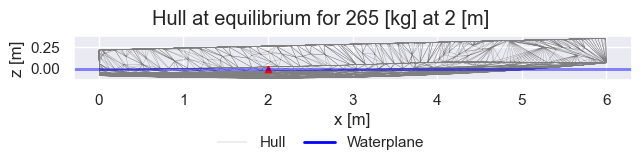

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [3 0 0]
	>>> Convergence reached in 4 iterations


{'disp_mass': 265.0014215648213,
 'disp_volume_m3': 0.2585379722583623,
 'cog_x': 3,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 4.231377812971012,
 'cob_x': 3.003587217770144,
 'cob_y': -3.2109832185679853e-06,
 'cob_z': -0.3057497568964177,
 'lcb_percent': 0.13129681191643325,
 'A_mid_m2': 0.06945543314558268,
 'angles_deg_x': 0.0015126052711364373,
 'angles_deg_y': 0.6756871183974993,
 'angles_deg_z': 1.195526735371779e-05,
 'LWL': 5.98729524,
 'BWL': 0.9593985899999999,
 'AWP': 3.98557090920442,
 'CWP': 0.6938423274719456,
 'CB': 0.3560225925120795,
 'CM': 0.5726511251143713,
 'CP': 0.6217094089197394,
 'draft_keel_m': 0.12642036208103447,
 'draft_mean_m': 0.03156525907759125,
 'draft_aft_m': 0.0012682153972124466,
 'draft_fwd_m': 0.061862302757970056,
 'x_wl_min': 0.00207847,
 'x_wl_max': 5.98937371}

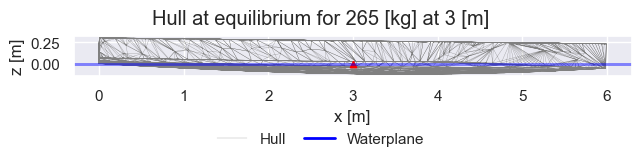

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [4 0 0]
	>>> Convergence reached in 6 iterations


{'disp_mass': 264.97770765561893,
 'disp_volume_m3': 0.2585148367371892,
 'cog_x': 4,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 3.246532581070441,
 'cob_x': 4.01938106717903,
 'cob_y': 9.105101097269536e-05,
 'cob_z': -0.26935177955586465,
 'lcb_percent': 4.379948902398515,
 'A_mid_m2': 0.08461187259866772,
 'angles_deg_x': -0.010697838390796825,
 'angles_deg_y': 4.047765812334767,
 'angles_deg_z': -0.0008077706406294224,
 'LWL': 4.28540461,
 'BWL': 0.93401304,
 'AWP': 2.6494644133744916,
 'CWP': 0.6619319111888976,
 'CB': 0.29310762600013174,
 'CM': 0.4111163831697716,
 'CP': 0.7129553527889745,
 'draft_keel_m': 0.22035026811320352,
 'draft_mean_m': 0.11027925659756282,
 'draft_aft_m': 0.0004764420404581027,
 'draft_fwd_m': 0.22008207115466755,
 'x_wl_min': 1.68898023,
 'x_wl_max': 5.97438484}

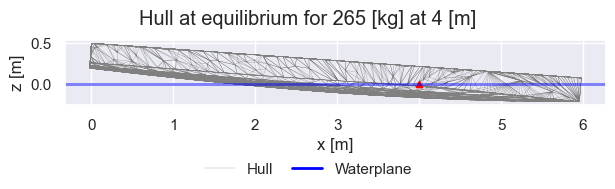

3DOF equilibrium
Target diplacement:    0.350 tons
COG pos:  [1 0 0]
	>>> Convergence reached in 7 iterations


{'disp_mass': 350.0181570420897,
 'disp_volume_m3': 0.3414811288215509,
 'cog_x': 1,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 3.1670594035945796,
 'cob_x': 0.9716804438579704,
 'cob_y': -4.030454020268313e-06,
 'cob_z': -0.22292584788391448,
 'lcb_percent': -17.360636708564552,
 'A_mid_m2': 0.09537431262223733,
 'angles_deg_x': -3.7460184123792815e-05,
 'angles_deg_y': -7.251846335301025,
 'angles_deg_z': 7.28332300955893e-05,
 'LWL': 2.96998644,
 'BWL': 1.0469258300000002,
 'AWP': 2.6134138764331483,
 'CWP': 0.8405001810322832,
 'CB': 0.3834596111283916,
 'CM': 0.3180817898788249,
 'CP': 1.2055377683660318,
 'draft_keel_m': 0.2864024306582044,
 'draft_mean_m': 0.14182297580734612,
 'draft_aft_m': 0.2864024306582044,
 'draft_fwd_m': -0.002756479043512173,
 'x_wl_min': 0.00229578,
 'x_wl_max': 2.97228222}

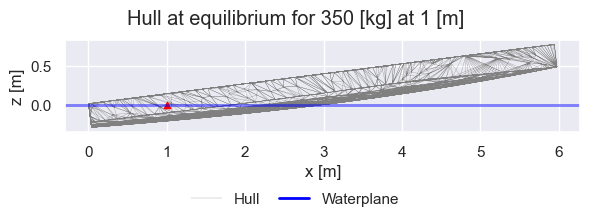

3DOF equilibrium
Target diplacement:    0.350 tons
COG pos:  [2 0 0]
	>>> Convergence reached in 4 iterations


{'disp_mass': 349.9766144346303,
 'disp_volume_m3': 0.34144059944841976,
 'cog_x': 2,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 4.414935797602229,
 'cob_x': 1.9927640348190812,
 'cob_y': -5.1731086266650944e-05,
 'cob_z': -0.2883720195380925,
 'lcb_percent': -12.985690662878977,
 'A_mid_m2': 0.06322479434778652,
 'angles_deg_x': 0.00028380079565689157,
 'angles_deg_y': -1.4605820717318607,
 'angles_deg_z': -5.582382653236314e-06,
 'LWL': 5.36816145,
 'BWL': 1.0591572500000002,
 'AWP': 4.111344114567285,
 'CWP': 0.7230990915609061,
 'CB': 0.44655750152537677,
 'CM': 0.44388985907781786,
 'CP': 1.0060096945064276,
 'draft_keel_m': 0.13447816012083405,
 'draft_mean_m': 0.054838937386668535,
 'draft_aft_m': 0.11231263371248482,
 'draft_fwd_m': -0.0026347589391477466,
 'x_wl_min': 0.00577615,
 'x_wl_max': 5.3739376}

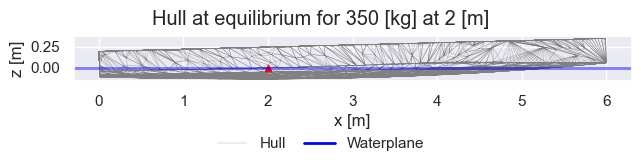

3DOF equilibrium
Target diplacement:    0.350 tons
COG pos:  [3 0 0]
	>>> Convergence reached in 4 iterations


{'disp_mass': 350.00267141225567,
 'disp_volume_m3': 0.34146602089000555,
 'cog_x': 3,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 4.702997774305836,
 'cob_x': 3.004419712504784,
 'cob_y': 3.7730469507363105e-06,
 'cob_z': -0.2929049748094913,
 'lcb_percent': 0.1929098707600076,
 'A_mid_m2': 0.09831367392878392,
 'angles_deg_x': -0.00038945219072886113,
 'angles_deg_y': 0.8649743488728509,
 'angles_deg_z': -8.67431537929214e-06,
 'LWL': 5.99241369,
 'BWL': 1.02969175,
 'AWP': 4.331174332613027,
 'CWP': 0.7019345898668854,
 'CB': 0.3699599633874814,
 'CM': 0.6382972117489001,
 'CP': 0.5796045424886174,
 'draft_keel_m': 0.14958351878245335,
 'draft_mean_m': 0.0523100537229538,
 'draft_aft_m': 0.012321169698324586,
 'draft_fwd_m': 0.09229893774758302,
 'x_wl_min': -0.00334709,
 'x_wl_max': 5.9890666}

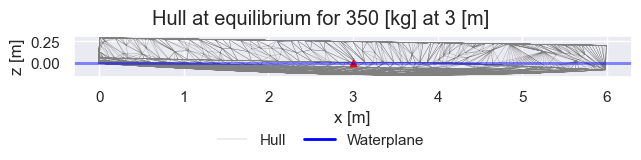

3DOF equilibrium
Target diplacement:    0.350 tons
COG pos:  [4 0 0]
	>>> Convergence reached in 6 iterations


{'disp_mass': 350.01554577463247,
 'disp_volume_m3': 0.34147858124354386,
 'cog_x': 4,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 3.6379767287200404,
 'cob_x': 4.021131900110918,
 'cob_y': -6.378528404941605e-05,
 'cob_z': -0.24849032027659682,
 'lcb_percent': 4.770643173269157,
 'A_mid_m2': 0.08515039692426245,
 'angles_deg_x': 0.005780446725741431,
 'angles_deg_y': 4.918822762897678,
 'angles_deg_z': 0.00043522615801704306,
 'LWL': 4.31414492,
 'BWL': 1.00606311,
 'AWP': 2.7944297034272583,
 'CWP': 0.6438330023772256,
 'CB': 0.2736263645226284,
 'CM': 0.2943580237106845,
 'CP': 0.9295699198998815,
 'draft_keel_m': 0.2875315950594809,
 'draft_mean_m': 0.14539590176124395,
 'draft_aft_m': 0.0032602084630070083,
 'draft_fwd_m': 0.2875315950594809,
 'x_wl_min': 1.65824698,
 'x_wl_max': 5.9723919}

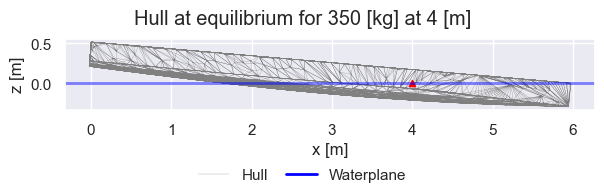

In [12]:
import os
from meshmagick import mmio, mesh

path = os.getcwd() + "/data/"
file = "hull_decimated.stl"


for mass in [100, 265, 350]:
    for cog_x in [1, 2, 3, 4]:
        V, F = mmio.load_STL(path + file)
        mymesh = mesh.Mesh(V, F)

        try:
            result = simulate(mymesh, mass=mass, cog_x=cog_x)
        except:
            continue
        display(result)

        fig_save_and_show(
            filename=f'{latex_img_path}/hull_loaded_{mass}kg-at-{cog_x}-m.pdf',
            show_title=f'Hull at equilibrium for {mass} [kg] at {cog_x} [m]',
            save_title=f'Casco em equilíbrio para {mass} [kg] em {cog_x} [m]',
            ncol=4,
            fig=plot_hull_position(result, mymesh),
        )

3DOF equilibrium
Target diplacement:    0.294 tons
COG pos:  [1.99 0.   0.  ]
	>>> Convergence reached in 5 iterations


{'disp_mass': 293.7090457102985,
 'disp_volume_m3': 0.28654541044907167,
 'cog_x': 1.99,
 'cog_y': 0.0,
 'cog_z': 0.0,
 'wet_surface_area': 4.156435797896883,
 'cob_x': 1.9829906192984132,
 'cob_y': -6.609895945847048e-07,
 'cob_z': -0.29637762038060556,
 'lcb_percent': -12.354342999138948,
 'A_mid_m2': 0.06628501687750367,
 'angles_deg_x': -0.0007055451793363508,
 'angles_deg_y': -1.3787872535470924,
 'angles_deg_z': -3.2866168757285984e-05,
 'LWL': 5.25180939,
 'BWL': 1.01558869,
 'AWP': 3.9245427785075218,
 'CWP': 0.735804189476706,
 'CB': 0.4460176404837,
 'CM': 0.5418547759115185,
 'CP': 0.8231313265319117,
 'draft_keel_m': 0.12045216485112642,
 'draft_mean_m': 0.04936803628868966,
 'draft_aft_m': 0.09552370656573134,
 'draft_fwd_m': 0.0032123660116479824,
 'x_wl_min': 0.00591247,
 'x_wl_max': 5.25772186}

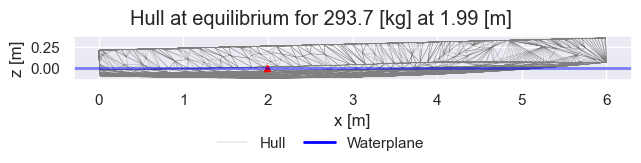

3DOF equilibrium
Target diplacement:    0.246 tons
COG pos:  [2.603 0.    0.   ]
	>>> Convergence reached in 3 iterations


{'disp_mass': 245.98302499456776,
 'disp_volume_m3': 0.2399834390190905,
 'cog_x': 2.603,
 'cog_y': 0.0,
 'cog_z': 0.0,
 'wet_surface_area': 4.165923257019643,
 'cob_x': 2.602228657600824,
 'cob_y': -2.549041536734666e-05,
 'cob_z': -0.310791807586365,
 'lcb_percent': -6.5869042807670635,
 'A_mid_m2': 0.05487078825220584,
 'angles_deg_x': 0.005176063377849394,
 'angles_deg_y': -0.06629359190504976,
 'angles_deg_z': -4.071831106754389e-06,
 'LWL': 5.99110539,
 'BWL': 0.95101599,
 'AWP': 3.9925266402286166,
 'CWP': 0.7007337644791378,
 'CB': 0.3737749784227748,
 'CM': 0.5120084294194547,
 'CP': 0.7300172359400077,
 'draft_keel_m': 0.11268763622622774,
 'draft_mean_m': 0.022704869417461027,
 'draft_aft_m': 0.030400127616078132,
 'draft_fwd_m': 0.015009611218843921,
 'x_wl_min': 0.00130434,
 'x_wl_max': 5.99240973}

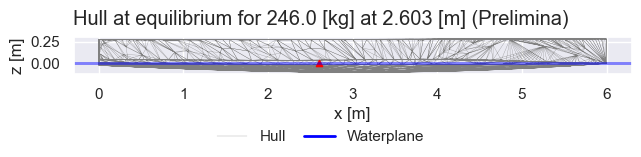

In [15]:
import os
from meshmagick import mmio, mesh

path = os.getcwd() + "/data/"
file = "hull_decimated.stl"

mass = 293.7
cog_x = 1.99

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

result = simulate(mymesh, mass=mass, cog_x=cog_x)
display(result)

fig_save_and_show(
    filename=f'{latex_img_path}/hull_loaded_2019_condition.pdf',
    show_title=f'Hull at equilibrium for {mass} [kg] at {cog_x} [m]',
    save_title=f'Casco em equilíbrio para {mass} [kg] em {cog_x} [m]',
    ncol=4,
    fig=plot_hull_position(result, mymesh),
)

###

mass = 246.0
cog_x = 2.603

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

result = simulate(mymesh, mass=mass, cog_x=cog_x)
display(result)

fig_save_and_show(
    filename=None,
    show_title=f'Hull at equilibrium for {mass} [kg] at {cog_x} [m] (Prelimina)',
    save_title=f'Casco em equilíbrio para {mass} [kg] em {cog_x} [m] (Prelimina)',
    ncol=4,
    fig=plot_hull_position(result, mymesh),
)